# Kvasir-HealthAI — Main (U-Net + Preprocessing + XAI)

This notebook demonstrates:
1) step-wise **preprocessing** with before/after previews,  
2) dataset loaders and **train-if-missing** logic (auto-load best checkpoint),  
3) **metrics plots** (history or saved images),  
4) **visual predictions** and **SegGrad-CAM** overlays.

Notes:
- Keep your repository layout with `src/` modules available.
- No unnecessary training: if the best checkpoint exists, training is skipped.


In [ ]:
# === Environment & Paths ===
import os, sys, random, platform, glob, json
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

# ---- Local imports (src) ----
# Dataset & model
from src.dataset import list_pairs, KvasirSegDataset
from src.models.unet import UNet

# Training & evaluation
from src.training.losses import BCEDiceLoss
from src.utils.metrics import dice_coeff, iou_score
from src.utils.visualization import overlay_mask

# Preprocessing pipeline
from src.preprocessing.pipeline import preprocess_staged_rgb_single
from src.preprocessing.specular_removal import remove_specular_highlight_safe
from src.preprocessing.homomorphic_filter import homomorphic_filter_soft
from src.preprocessing.guided_filter import guided_filter
from src.preprocessing.clahe import apply_clahe
from src.preprocessing.retone import retone_to_target

# Explainability
from src.explainability.gradcam import SegGradCAM

# ---- Environment info ----
print("Python:", platform.python_version())
print("Torch :", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# If the notebook runs from kvasir-healthai/notebooks, use project root one level up.
CWD = os.getcwd()
if os.path.basename(CWD).lower() == "notebooks":
    PROJECT_ROOT = os.path.abspath(os.path.join(CWD, ".."))
else:
    PROJECT_ROOT = CWD

SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)  # so "src.*" can be imported

# Reproducibility & device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE} | Torch: {torch.__version__} | CUDA: {getattr(torch.version, 'cuda', None)}")

# Dataset paths 

DATA_ROOT = r"D:\Projects\Kvasir-Seg_Project\Kvasir-SEG"

def resolve_kvasir_dirs(root: str):
    """Handle Images/Masks vs images/masks name variations safely."""
    img_candidates = ["images", "Images", "image", "Image"]
    msk_candidates = ["masks", "Masks", "mask", "Mask"]
    im_dir = ms_dir = None
    for name in img_candidates:
        p = os.path.join(root, name)
        if os.path.isdir(p):
            im_dir = p; break
    for name in msk_candidates:
        p = os.path.join(root, name)
        if os.path.isdir(p):
            ms_dir = p; break
    return im_dir, ms_dir

IM_DIR, MSK_DIR = resolve_kvasir_dirs(DATA_ROOT)

# Fail fast if something is wrong
assert os.path.isdir(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}"
assert IM_DIR is not None and os.path.isdir(IM_DIR), f"Image folder not found under {DATA_ROOT}"
assert MSK_DIR is not None and os.path.isdir(MSK_DIR), f"Mask folder not found under {DATA_ROOT}"

print("DATA_ROOT:", DATA_ROOT)
print("IM_DIR   :", IM_DIR)
print("MSK_DIR  :", MSK_DIR)

# Core hyperparameters 

IMG_SIZE     = 256
BATCH_SIZE   = 8
EPOCHS       = 40
LR           = 1e-3
WEIGHT_DECAY = 0.0          # set >0 if you want L2 regularization (e.g., 1e-4)
VAL_SPLIT    = 0.20         # used only when splitting pairs in-notebook
USE_AMP      = False        # mixed precision (enable later if stable on your GPU)

print(f"IMG_SIZE={IMG_SIZE} | BATCH_SIZE={BATCH_SIZE} | EPOCHS={EPOCHS} | LR={LR} | WD={WEIGHT_DECAY} | VAL_SPLIT={VAL_SPLIT}")


Device: cuda | Torch: 2.3.1+cu118 | CUDA: 11.8
DATA_ROOT: D:\Projects\Kvasir-Seg_Project\Kvasir-SEG
IM_DIR   : D:\Projects\Kvasir-Seg_Project\Kvasir-SEG\images
MSK_DIR  : D:\Projects\Kvasir-Seg_Project\Kvasir-SEG\masks
IMG_SIZE=256 | BATCH_SIZE=8 | EPOCHS=40 | LR=0.001 | WD=0.0 | VAL_SPLIT=0.2


## Preprocessing Overview

We apply a staged pipeline to improve illumination and contrast while preserving structure:

1. Specular highlight removal (safe inpainting on small glare areas)  
2. Homomorphic filtering on V channel (illumination normalization)  
3. Guided filtering on V (edge-preserving smoothing)  
4. CLAHE on V (local contrast boost)  
5. Retone (match mean/std to a target window)

Below, each stage is shown with before/after previews on a sample image.


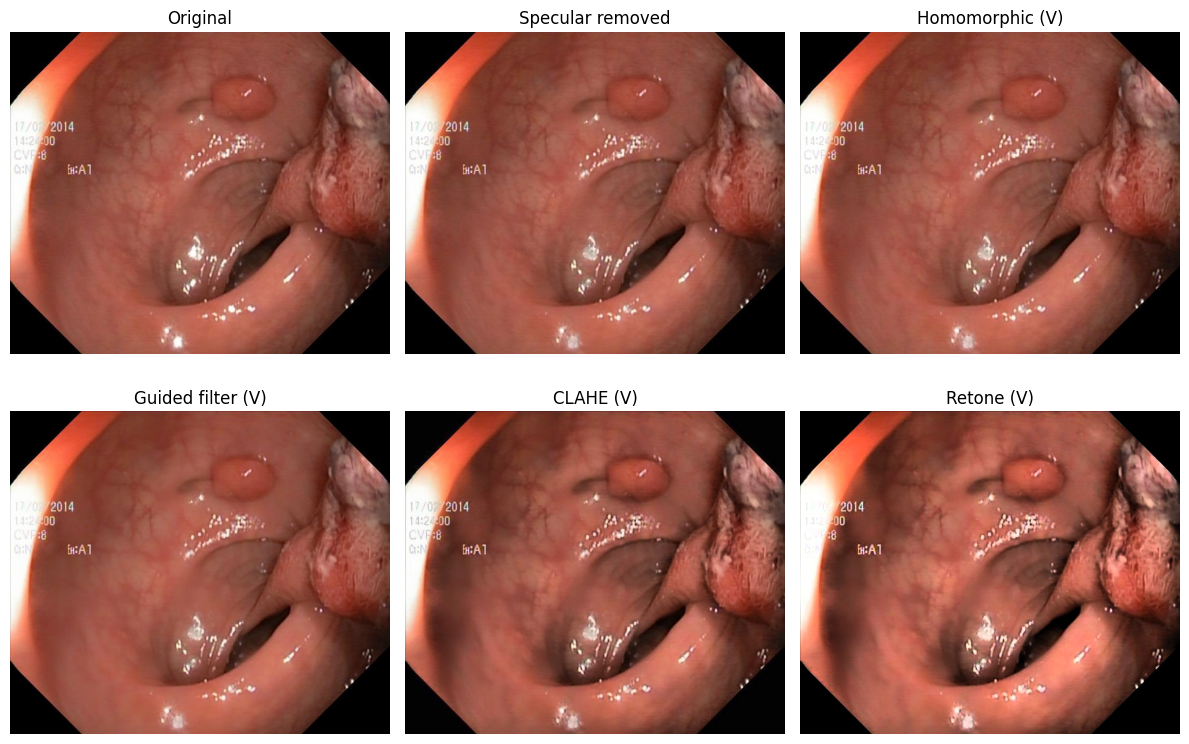

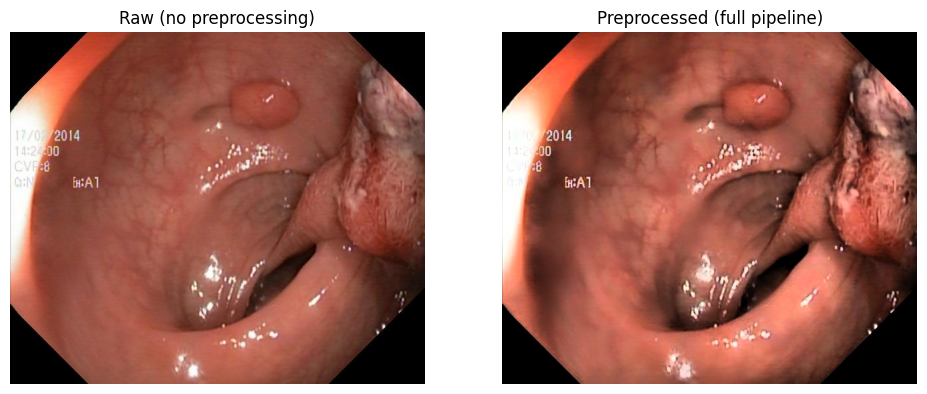

In [30]:
# Utilities to convert BGR<->RGB for display
def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def rgb_to_bgr(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# Run each preprocessing stage separately for visualization
def run_preproc_stages(bgr):
    steps = []

    # 0) Original
    steps.append(("Original", bgr.copy()))

    # 1) Specular removal
    b1, mask_sp = remove_specular_highlight_safe(bgr)
    steps.append(("Specular removed", b1))

    # 2) Homomorphic (on V)
    h, s, v = cv2.split(cv2.cvtColor(b1, cv2.COLOR_BGR2HSV))
    v2 = homomorphic_filter_soft(v)
    b2 = cv2.cvtColor(cv2.merge([h, s, v2]), cv2.COLOR_HSV2BGR)
    steps.append(("Homomorphic (V)", b2))

    # 3) Guided filter (on V)
    h, s, v = cv2.split(cv2.cvtColor(b2, cv2.COLOR_BGR2HSV))
    v3 = guided_filter(v)
    b3 = cv2.cvtColor(cv2.merge([h, s, v3]), cv2.COLOR_HSV2BGR)
    steps.append(("Guided filter (V)", b3))

    # 4) CLAHE (on V)
    h, s, v = cv2.split(cv2.cvtColor(b3, cv2.COLOR_BGR2HSV))
    v4 = apply_clahe(v)
    b4 = cv2.cvtColor(cv2.merge([h, s, v4]), cv2.COLOR_HSV2BGR)
    steps.append(("CLAHE (V)", b4))

    # 5) Retone (on V)
    h, s, v = cv2.split(cv2.cvtColor(b4, cv2.COLOR_BGR2HSV))
    v5 = retone_to_target(v)
    b5 = cv2.cvtColor(cv2.merge([h, s, v5]), cv2.COLOR_HSV2BGR)
    steps.append(("Retone (V)", b5))

    return steps

# Pick a sample pair and visualize all stages
pairs = list_pairs(IM_DIR, MSK_DIR)
assert len(pairs) > 0, "No image/mask pairs found. Check IM_DIR/MSK_DIR."
sample_ip, _ = pairs[3]

bgr = cv2.imread(sample_ip)
assert bgr is not None, f"Failed to read image: {sample_ip}"

stages = run_preproc_stages(bgr)

# Plot as a grid: 3 columns per row
cols = 3
rows = int(np.ceil(len(stages) / cols))
plt.figure(figsize=(12, 4*rows))
for i, (title, img_bgr) in enumerate(stages):
    plt.subplot(rows, cols, i+1)
    plt.imshow(bgr_to_rgb(img_bgr))
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Side-by-side: raw vs fully processed (pipeline)
full_processed = preprocess_staged_rgb_single(bgr)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(bgr_to_rgb(bgr));             plt.title("Raw (no preprocessing)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(bgr_to_rgb(full_processed));  plt.title("Preprocessed (full pipeline)"); plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
# Hyperparams (align with earlier cells)
IMG_SIZE    = 256
BATCH_SIZE  = 8
VAL_SPLIT   = 0.2

# List pairs and split
pairs = list_pairs(IM_DIR, MSK_DIR)
assert len(pairs) > 0, f"No pairs found under {IM_DIR} / {MSK_DIR}"

# Deterministic split
rng = np.random.default_rng(42)
idx = np.arange(len(pairs))
rng.shuffle(idx)
cut = int((1.0 - VAL_SPLIT) * len(idx))
train_idx, val_idx = idx[:cut], idx[cut:]

tr_pairs = [pairs[i] for i in train_idx]
va_pairs = [pairs[i] for i in val_idx]

print(f"Total pairs: {len(pairs)} | Train: {len(tr_pairs)} | Val: {len(va_pairs)}")

# Build loaders
train_loader = torch.utils.data.DataLoader(
    KvasirSegDataset(tr_pairs, img_size=IMG_SIZE, is_train=True),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    KvasirSegDataset(va_pairs, img_size=IMG_SIZE, is_train=False),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

# Peek one batch (from val) to ensure shapes
xb, yb = next(iter(val_loader))
print("Val batch X:", tuple(xb.shape), "| Y:", tuple(yb.shape))


Total pairs: 1000 | Train: 800 | Val: 200
Val batch X: (8, 3, 256, 256) | Y: (8, 1, 256, 256)


## Model — load best checkpoint (skip training if found)

This cell tries to load the best U-Net weights from  
`assets/results/unet/best_unet.pt`.

- If the checkpoint **exists**, we skip training and just load the model.
- If it **does not exist**, you can enable `AUTO_TRAIN_IF_MISSING=True` to trigger training via the package trainer.  
  (Left `False` by default to avoid accidental long runs.)


In [32]:
import os, subprocess, sys, torch
from src.models.unet import UNet

# Where we expect the best checkpoint
def _paths_for_unet():
    ck_dir = os.path.join("assets", "results", "unet")
    os.makedirs(ck_dir, exist_ok=True)
    return ck_dir, os.path.join(ck_dir, "best_unet.pt")

def build_unet_for_infer(base=64, in_ch=3, out_ch=1, device=None):
    m = UNet(in_ch=in_ch, out_ch=out_ch, base=base)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return m.to(device).eval()

AUTO_TRAIN_IF_MISSING = False  # set True ONLY if you really want to auto-train when missing

def load_or_train_unet(base=64):
    ck_dir, ck_path = _paths_for_unet()
    if os.path.exists(ck_path):
        # Load checkpoint (CPU first → move to DEVICE)
        state = torch.load(ck_path, map_location="cpu")
        model = build_unet_for_infer(base=base, device=DEVICE)
        model.load_state_dict(state, strict=True)
        model.eval()
        print(f"[unet] Loaded best checkpoint → {ck_path}")
        return model, ck_path, True

    print(f"[unet] Checkpoint not found at {ck_path}.")
    if not AUTO_TRAIN_IF_MISSING:
        print("[unet] Training is disabled by default. "
              "Set AUTO_TRAIN_IF_MISSING=True to run the training script, or execute your training cell manually.")
        return None, ck_path, False

    # Optional: call the packaged trainer (python -m src.training.train)
    print("[unet] Starting training via package trainer (this can take a while)...")
    cmd = [sys.executable, "-m", "src.training.train"]
    ret = subprocess.run(cmd, cwd=os.getcwd())
    if ret.returncode != 0:
        raise RuntimeError("Training process failed. Check logs above.")

    # Try loading again
    if not os.path.exists(ck_path):
        raise FileNotFoundError(f"Training finished but checkpoint not found at {ck_path}.")
    state = torch.load(ck_path, map_location="cpu")
    model = build_unet_for_infer(base=base, device=DEVICE)
    model.load_state_dict(state, strict=True)
    model.eval()
    print(f"[unet] Trained and loaded → {ck_path}")
    return model, ck_path, True

# Execute
unet, ckpt_path, loaded = load_or_train_unet(base=64)


[unet] Loaded best checkpoint → assets\results\unet\best_unet.pt


## Inference & qualitative results

We run a quick forward pass on a validation batch and visualize:
- Input image
- Ground-truth mask
- Model prediction (thresholded at 0.5)

This is a fast sanity check to confirm the checkpoint behaves as expected.


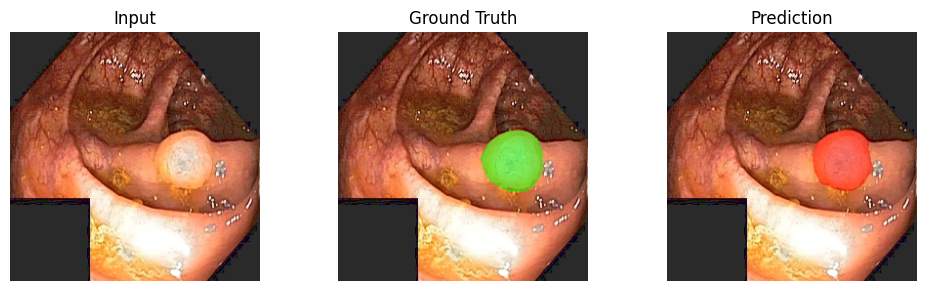

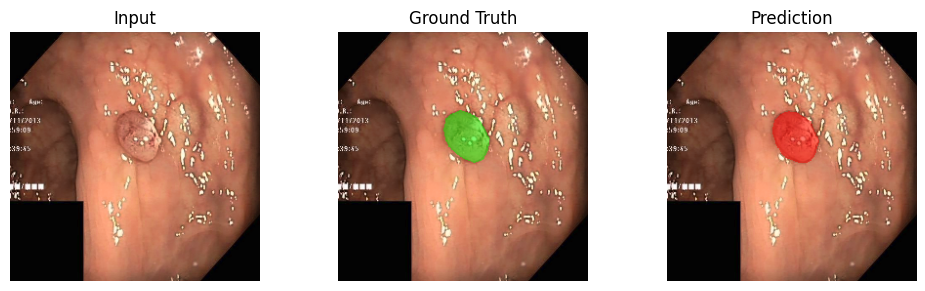

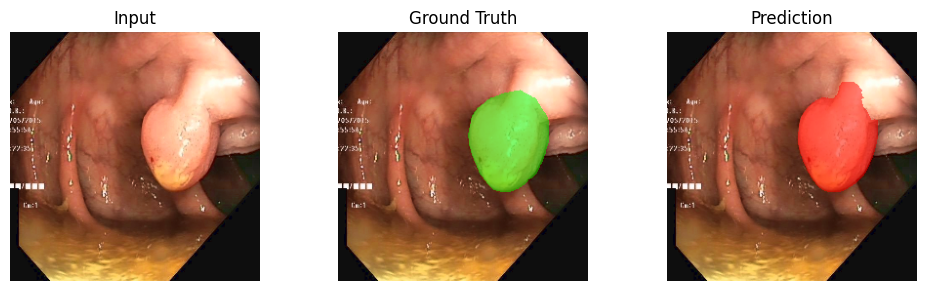

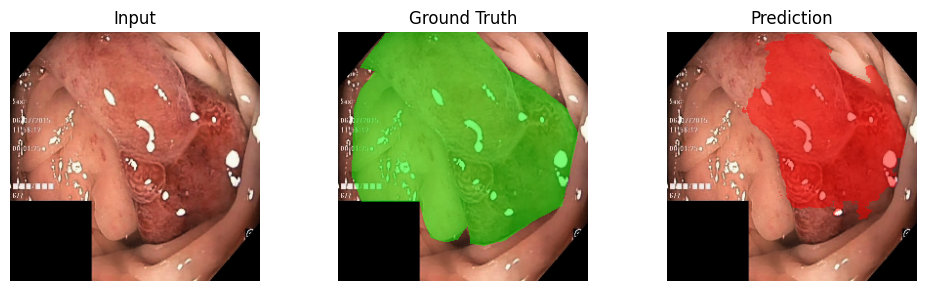

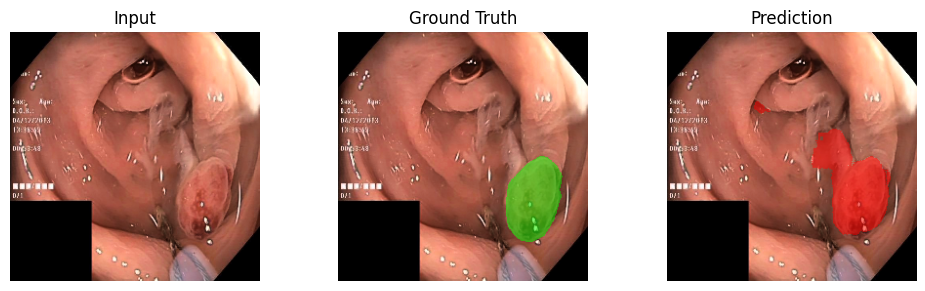

In [ ]:
assert unet is not None, "Model not loaded. Run the previous cell to load the checkpoint."

unet.eval()
xb = yb = preds = None

# 1) Take one validation batch
with torch.no_grad():
    for xb_, yb_ in val_loader:
        xb = xb_.to(DEVICE)
        yb = yb_.to(DEVICE)
        preds = torch.sigmoid(unet(xb))
        break

# 2) Visualize up to n samples (clip to batch size)
n = 5
n_show = min(n, xb.size(0))

for i in range(n_show):
    # to uint8 RGB
    rgb = (xb[i].detach().permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
    # GT (0/1)
    m_true = (yb[i, 0].detach().cpu().numpy() > 0.5).astype(np.uint8)
    # prediction → threshold 0.5
    m_pred = (preds[i, 0].detach().cpu().numpy() > 0.5).astype(np.uint8)

    # overlays (green = GT, red = pred)
    ov_true = overlay_mask(rgb, m_true, color=(0,255,0))
    ov_pred = overlay_mask(rgb, m_pred, color=(255,0,0))

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(rgb);     ax[0].set_title("Input");        ax[0].axis('off')
    ax[1].imshow(ov_true); ax[1].set_title("Ground Truth"); ax[1].axis('off')
    ax[2].imshow(ov_pred); ax[2].set_title("Prediction");   ax[2].axis('off')
    plt.tight_layout(); plt.show()


## Explainability — Grad-CAM (decoder side)

We compute a Grad-CAM heatmap from a late decoder conv layer to see **where** the U-Net focuses while producing the mask.
- Target layer: a deep decoder conv (fallback: last `Conv2d` in the model).
- For each sample we show: *Input*, *Grad-CAM heatmap*, *Overlay*.


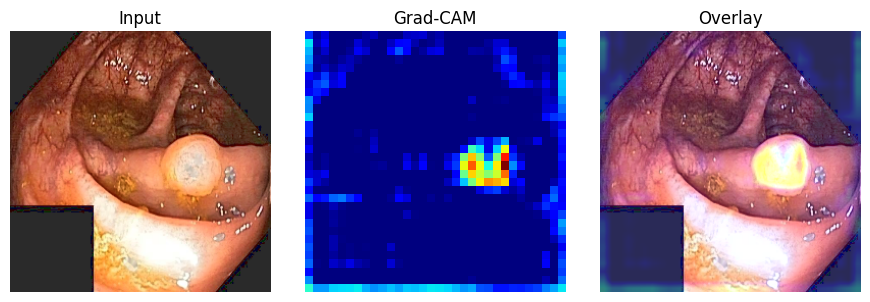

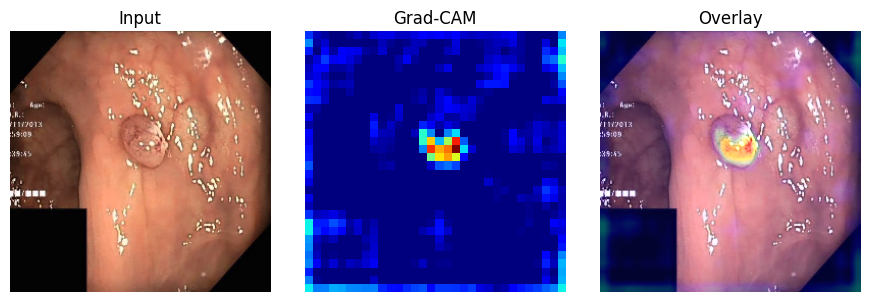

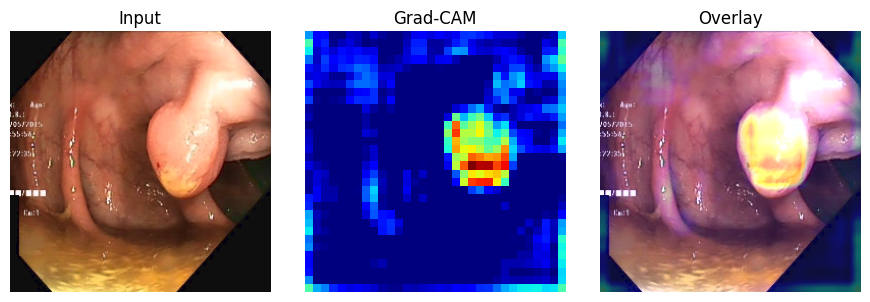

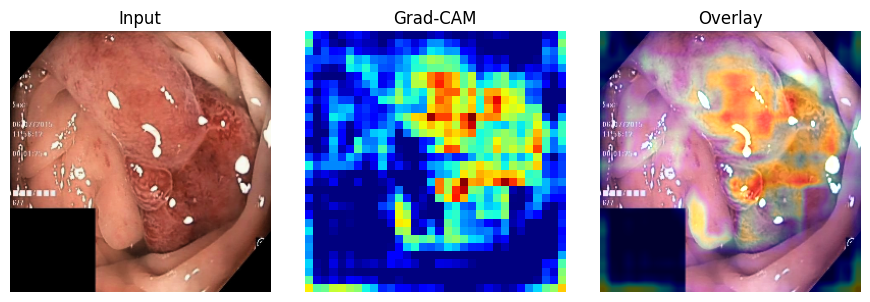

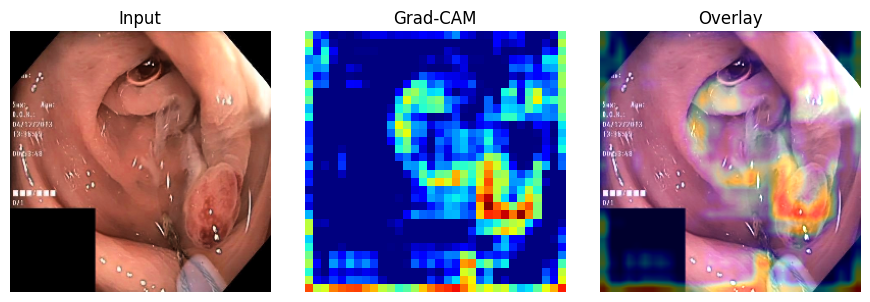

In [ ]:
assert unet is not None, "Model not loaded. Run the load cell first."
unet.eval()

def pick_unet_target(model):
    """Prefer a late decoder conv; fallback to the last Conv2d in the network."""
    try:
        return model.dec4.conv[3]  # a reasonably deep decoder conv
    except Exception:
        last = None
        for m in model.modules():
            if isinstance(m, torch.nn.Conv2d):
                last = m
        return last

def show_gradcam_samples(model, loader, n=5, alpha=0.35):
    """Draw Grad-CAM for up to n validation images."""
    target = pick_unet_target(model)
    if target is None:
        print("[Grad-CAM] No suitable target layer found."); 
        return

    engine = SegGradCAM(model, target_layer=target, device=DEVICE)
    shown = 0

    for xb, _ in loader:
        bs = xb.size(0)
        for i in range(bs):
            if shown >= n:
                engine.close()
                return

            # keep autograd enabled for Grad-CAM
            x = xb[i:i+1].to(DEVICE).requires_grad_(True)
            with torch.enable_grad():
                _, cam = engine.generate(x)

            # x (CHW, [0..1]) -> RGB uint8 for display
            rgb = (x[0].detach().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # engine.overlay expects BGR; convert RGB->BGR then overlay, then back to RGB for plt
            overlay = engine.overlay(rgb[:, :, ::-1], cam, alpha=alpha)

            # plot
            plt.figure(figsize=(9, 3))
            ax1 = plt.subplot(1, 3, 1); ax1.imshow(rgb);            ax1.set_title("Input");   ax1.axis("off")
            ax2 = plt.subplot(1, 3, 2); ax2.imshow(cam, cmap="jet"); ax2.set_title("Grad-CAM"); ax2.axis("off")
            ax3 = plt.subplot(1, 3, 3); ax3.imshow(overlay);        ax3.set_title("Overlay"); ax3.axis("off")
            plt.tight_layout(); plt.show()

            shown += 1

    engine.close()

# Run Grad-CAM on up to 5 validation samples
show_gradcam_samples(unet, val_loader, n=5, alpha=0.35)


## Quantitative evaluation (Dice / IoU) on the validation set

We evaluate the loaded checkpoint on the entire validation set:

- **Soft Dice** (no threshold; probability maps)
- **Binary IoU** (threshold = 0.5)

Results are printed and also saved to `assets/results/unet/eval_val.json`.


In [ ]:
assert unet is not None, "Model not loaded. Run the load cell first."

def eval_on_val(model, loader, threshold=0.5, eps=1e-6):
    model.eval()
    dice_soft_all, iou_bin_all = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            logits = model(xb)
            probs  = torch.sigmoid(logits).float()

            # --- soft Dice (per-sample, then mean) ---
            dims = (1, 2, 3)  # (C,H,W) over channel-first tensors
            inter = (probs * yb).sum(dim=dims)
            denom = (probs*probs).sum(dim=dims) + (yb*yb).sum(dim=dims) + eps
            dice_soft = (2.0 * inter + eps) / denom                  # [B]
            dice_soft_all.append(dice_soft.detach().cpu().numpy())

            # --- binary IoU (per-sample, then mean) ---
            pred_bin = (probs > threshold).float()
            inter_b  = (pred_bin * yb).sum(dim=dims)
            union_b  = (pred_bin + yb).clamp_(0, 1).sum(dim=dims) + eps
            iou_bin  = inter_b / union_b                              # [B]
            iou_bin_all.append(iou_bin.detach().cpu().numpy())

    dice_mean = float(np.concatenate(dice_soft_all, axis=0).mean()) if dice_soft_all else 0.0
    iou_mean  = float(np.concatenate(iou_bin_all, axis=0).mean())   if iou_bin_all  else 0.0
    return dice_mean, iou_mean

dice_val, iou_val = eval_on_val(unet, val_loader, threshold=0.5)

print(f"Validation — Soft Dice: {dice_val:.4f} | Binary IoU@0.5: {iou_val:.4f}")

# Save to JSON alongside other results
ck_dir = os.path.join("assets", "results", "unet")
os.makedirs(ck_dir, exist_ok=True)
out_json = os.path.join(ck_dir, "eval_val.json")
with open(out_json, "w") as f:
    json.dump({"dice_soft": dice_val, "iou_bin@0.5": iou_val}, f, indent=2)
print(f"Saved evaluation to {out_json}")


Validation — Soft Dice: 0.9413 | Binary IoU@0.5: 0.8829
Saved evaluation to assets\results\unet\eval_val.json


## Single-image inference & overlay saving

This utility:
- loads a single image path,
- applies the same preprocessing pipeline,
- runs the U-Net checkpoint,
- rescales the prediction back to the original size,
- saves input / probmap / binary mask / overlay under `assets/results/inference/`.

Use this to quickly sanity-check arbitrary images.


In [ ]:
assert unet is not None, "Model not loaded. Run the load cell first."

INF_OUT_DIR = os.path.join("assets", "results", "inference")
os.makedirs(INF_OUT_DIR, exist_ok=True)

def _basename_noext(path: str) -> str:
    base = os.path.basename(path)
    name, _ = os.path.splitext(base)
    return name

@torch.no_grad()
def predict_single_image(
    img_path: str,
    model: torch.nn.Module,
    device: torch.device = None,
    img_size: int = 256,
    thr: float = 0.5,
    save_dir: str = INF_OUT_DIR,
    visualize: bool = True
):
    """
    Run the full pipeline on one image:
    - read BGR, preprocess to BGR,
    - convert to RGB tensor (C,H,W) in [0,1],
    - forward pass, sigmoid,
    - upsample prob to original size,
    - threshold to binary,
    - save input/prob/mask/overlay,
    - optionally show with matplotlib.

    Returns: dict with np arrays and output file paths.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    # --- read & preprocess (BGR) ---
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"Failed to read image: {img_path}")
    h0, w0 = bgr.shape[:2]

    bgr_p = preprocess_staged_rgb_single(bgr)

    # --- to RGB & model input ---
    rgb_p = cv2.cvtColor(bgr_p, cv2.COLOR_BGR2RGB)
    rgb_resized = cv2.resize(rgb_p, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    x = torch.from_numpy(rgb_resized.transpose(2,0,1)).unsqueeze(0).float() / 255.0
    x = x.to(device)

    # --- forward ---
    model.eval()
    probs_small = torch.sigmoid(model(x))[0, 0].detach().cpu().numpy()  # (H,W) in [0,1]
    # back to original size
    prob = cv2.resize(probs_small, (w0, h0), interpolation=cv2.INTER_LINEAR)

    # --- binary mask ---
    mask_bin = (prob > thr).astype(np.uint8)

    # --- overlays / visualizations ---
    # original RGB (no preprocessing) for a fair visual reference
    rgb_orig = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    overlay_pred = overlay_mask(rgb_orig, mask_bin, alpha=0.5, color=(255,0,0))

    # --- save ---
    stem = _basename_noext(img_path)
    p_input   = os.path.join(save_dir, f"{stem}_input.png")
    p_prob    = os.path.join(save_dir, f"{stem}_prob.png")
    p_mask    = os.path.join(save_dir, f"{stem}_mask.png")
    p_overlay = os.path.join(save_dir, f"{stem}_overlay.png")

    # input
    cv2.imwrite(p_input, cv2.cvtColor(rgb_orig, cv2.COLOR_RGB2BGR))
    # probmap as a grayscale heat (matplotlib -> PNG)
    plt.figure(figsize=(4,4))
    plt.imshow(prob, cmap="jet")
    plt.axis("off"); plt.tight_layout()
    plt.savefig(p_prob, dpi=140, bbox_inches="tight", pad_inches=0)
    plt.close()
    # binary mask
    cv2.imwrite(p_mask, (mask_bin*255))
    # overlay (convert back to BGR for imwrite)
    cv2.imwrite(p_overlay, cv2.cvtColor(overlay_pred, cv2.COLOR_RGB2BGR))

    if visualize:
        fig, ax = plt.subplots(1, 4, figsize=(12, 3))
        ax[0].imshow(rgb_orig);  ax[0].set_title("Input");   ax[0].axis("off")
        ax[1].imshow(prob, cmap="jet"); ax[1].set_title("Prob"); ax[1].axis("off")
        ax[2].imshow(mask_bin, cmap="gray"); ax[2].set_title("Mask"); ax[2].axis("off")
        ax[3].imshow(overlay_pred); ax[3].set_title("Overlay"); ax[3].axis("off")
        plt.tight_layout(); plt.show()

    return {
        "input_rgb": rgb_orig,
        "prob": prob,
        "mask_bin": mask_bin,
        "overlay_rgb": overlay_pred,
        "paths": {
            "input": p_input, "prob": p_prob, "mask": p_mask, "overlay": p_overlay
        }
    }

# Example usage:
# result = predict_single_image("assets/images/test_sample.png", unet, device=DEVICE, img_size=IMG_SIZE, thr=0.5)
# print(result["paths"])


## Notebook summary & outputs

This notebook demonstrated the full segmentation workflow:
1. Dataset loading and inspection (Kvasir-SEG).  
2. Preprocessing pipeline (contrast, homomorphic, guided filtering).  
3. Model training or checkpoint loading.  
4. Validation metrics (Dice / IoU).  
5. Explainability with Grad-CAM.  
6. Single-image inference and overlay generation.

All results were written under:
- assets/results/unet/
- assets/results/inference/

In [ ]:
import os, glob, json

def summarize_outputs():
    print("=== Output summary ===")
    # training results
    res_dir = os.path.join("assets", "results", "unet")
    inf_dir = os.path.join("assets", "results", "inference")

    eval_path = os.path.join(res_dir, "eval_val.json")
    if os.path.exists(eval_path):
        with open(eval_path) as f:
            metrics = json.load(f)
        print(f"[Validation Metrics] Dice: {metrics.get('dice_soft', 'N/A'):.4f}, IoU: {metrics.get('iou_bin@0.5', 'N/A'):.4f}")
    else:
        print("No eval_val.json found — metrics may not have been computed.")

    ckpts = glob.glob(os.path.join(res_dir, "*.pt")) + glob.glob(os.path.join(res_dir, "*.pth"))
    print(f"Checkpoints: {len(ckpts)} file(s)")
    for ck in ckpts:
        print(" └─", ck)

    inf_imgs = glob.glob(os.path.join(inf_dir, "*.png"))
    print(f"Inference outputs: {len(inf_imgs)} image(s)")
    if inf_imgs:
        print(" └─ Sample:", inf_imgs[:3])

summarize_outputs()
